## Variable importance

Calculate, plot and compare variable importance for models v1 and v2, agaist pearson´s R2 coeff.

In [1]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
import os

from tensorflow.keras.models import load_model

from sklearn.inspection import permutation_importance

from matplotlib.colors import CenteredNorm, LinearSegmentedColormap

sys.path.append("../..")

from src.processing import windsat_datacube, model_preprocess, \
    telsem_datacube, doy2month_mapping

from src.model import xy_split


# Files
ws_path = "../../data/raw/daily_windsat/"
telsem_folder = r"..\..\data\processed\WindsatEmiss"


In [2]:
# Define / load the models

regressions = { # Swath : (a,b)
    0 : (0.56, 138.29),
    1 : (0.54 , 142.98)
}

model_folder = "..\..\models"

modelsv1 = {
    0 : load_model(os.path.join(model_folder, "WSMv1_A_2024_07_23T135732" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv1_D_2024_07_23T120006" + ".keras")),
}

modelsv2 = {
    0 : load_model(os.path.join(model_folder, "WSMv2_A_2024_07_23T202640" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv2_D_2024_07_23T180208" + ".keras")),
}

In [3]:
# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")

In [4]:
# Preprocessing of windsat datacube
ws_ds = windsat_datacube(ws_path)
swath = 0 

In [5]:
# Load the combined dataframe

swath_ds= model_preprocess(ws_ds, swath_sector=swath, look="impute", add_look_flag=False)
swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()
swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
df = df.drop(columns="month")

# Save the original lat lon for plotting later
lat = df["lat"].copy()
lon = df["lon"].copy()

df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

# Model v2 predictions

model = modelsv2[swath]

# Predict for the local sample:
X, y = xy_split(df, y_column = "surtep_ERA5")
df["surtep_MODEL"] = model.predict(X)
df["v2_error"] = df["surtep_MODEL"] - df["surtep_ERA5"] 

# Re add lon and lat as they were
df["lat"] = lat
df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
v2error_df = df[["lat","lon","v2_error"]]
v2error_df.set_index(keys=["lat","lon"], inplace=True)
v2error_df = v2error_df.groupby(by=["lat","lon"]).mean()
v2error_df.reset_index(inplace=True)

print("Variable importances")
var_importances = permutation_importance(
model, X, y,
scoring="neg_median_absolute_error",
max_samples= 0.1, # We have a lot of data, use only 10 % 
n_repeats=3
)

# Get te results into a readable table:
importance = var_importances.importances_mean
importances ={var:value for var,value in zip(X.columns, importance)}

# dataframe format
importancesv2_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
importancesv2_df["importance"] = importancesv2_df["importance [mse]"] / importancesv2_df["importance [mse]"].sum()


52364/52364 ━━━━━━━━━━━━━━━━━━━━ 27s 504us/step
Variable importances
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 35s 665us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 630us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 610us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 614us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 611us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 691us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 725us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 591us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 637us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 586us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 611us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 811us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 581us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 917us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 636us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 875us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 937us/step
5237/5237 ━━━━━━━━━━━━━━━━━━

In [6]:
# Pearson's R2 coeff
r2_values_list = []
for column in X.columns:
    # Compute the Pearson correlation coefficient between the feature and y
    r = np.corrcoef(X[column], y)[0, 1]
    # Square the correlation coefficient to get R^2
    r2 = r**2
    # Append the result to the DataFrame
    r2_values_list.append({'Feature': column, 'R^2': r2})

r2_values = pd.DataFrame(r2_values_list)


In [7]:
# Select the variables for model v1 and calculate the mse
lat = df["lat"].copy()
lon = df["lon"].copy()

df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

model = modelsv1[swath]

df = df[
    [
        'surtep_ERA5',
        'lat',
        'lon',
        'tbtoa_18Ghz_V',
        'tbtoa_18Ghz_H',
        'tbtoa_37Ghz_V',
        'tbtoa_37Ghz_H'
    ]
]

# Predict for the local sample:
X, y = xy_split(df, y_column = "surtep_ERA5")
df["surtep_MODEL"] = model.predict(X)
df["v1_error"] = df["surtep_MODEL"] - df["surtep_ERA5"] 

# Re add lon and lat as they were
df["lat"] = lat
df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
v1error_df = df[["lat","lon","v1_error"]]
v1error_df.set_index(keys=["lat","lon"], inplace=True)
v1error_df = v2error_df.groupby(by=["lat","lon"]).mean()
v1error_df.reset_index(inplace=True)

print("Variable importances")
var_importances = permutation_importance(
model, X, y,
scoring="neg_median_absolute_error",
max_samples= 0.1, # We have a lot of data, use only 10 % 
n_repeats=3
)

# Get te results into a readable table:
importance = var_importances.importances_mean
importances ={var:value for var,value in zip(X.columns, importance)}


# dataframe format
importancesv1_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
importancesv1_df["importance"] = importancesv1_df["importance [mse]"] / importancesv1_df["importance [mse]"].sum()

52364/52364 ━━━━━━━━━━━━━━━━━━━━ 35s 664us/step
Variable importances
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 33s 629us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 590us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 631us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 643us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 633us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 636us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 653us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 704us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 647us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 719us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 627us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 637us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 716us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 614us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 621us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 633us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 621us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 660us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 634us/step


In [8]:
r2_values

,Feature,R^2
0,lat,0.116907
1,lon,0.004545
2,tbtoa_18Ghz_V,0.504210
3,tbtoa_18Ghz_H,0.154947
4,tbtoa_37Ghz_V,0.551042
5,tbtoa_37Ghz_H,0.201923
6,Emis19V,0.019133
7,Emis19H,0.000470
8,Emis37V,0.010073
9,Emis37H,0.000118


In [9]:
importancesv1_df

,importance [mse],importance
lat,1.219747,0.047486
lon,0.179143,0.006974
tbtoa_18Ghz_V,6.313207,0.245781
tbtoa_18Ghz_H,3.348028,0.130343
tbtoa_37Ghz_V,11.345729,0.441703
tbtoa_37Ghz_H,3.280472,0.127713


In [10]:
importancesv2_df

,importance [mse],importance
lat,0.772573,0.031387
lon,0.078069,0.003172
tbtoa_18Ghz_V,7.754486,0.315039
tbtoa_18Ghz_H,3.118871,0.126709
tbtoa_37Ghz_V,6.137812,0.249359
tbtoa_37Ghz_H,3.318512,0.134820
Emis19V,0.729650,0.029643
Emis19H,0.561325,0.022805
Emis37V,0.925023,0.037581
Emis37H,1.218048,0.049485


In [14]:
# Combine the dataframes 

results_df = r2_values.merge(importancesv2_df.reset_index(names="Feature"), how = "outer", on="Feature")
results_df = results_df.merge(importancesv1_df.reset_index(names="Feature"), how = "outer", on="Feature", suffixes=("_v2","_v1"))
results_df = results_df[::-1]
results_df

,Feature,R^2,importance [mse]_v2,importance_v2,importance [mse]_v1,importance_v1
9,tbtoa_37Ghz_V,0.551042,6.137812,0.249359,11.345729,0.441703
8,tbtoa_37Ghz_H,0.201923,3.318512,0.134820,3.280472,0.127713
7,tbtoa_18Ghz_V,0.504210,7.754486,0.315039,6.313207,0.245781
6,tbtoa_18Ghz_H,0.154947,3.118871,0.126709,3.348028,0.130343
5,lon,0.004545,0.078069,0.003172,0.179143,0.006974
4,lat,0.116907,0.772573,0.031387,1.219747,0.047486
3,Emis37V,0.010073,0.925023,0.037581,NaN,NaN
2,Emis37H,0.000118,1.218048,0.049485,NaN,NaN
1,Emis19V,0.019133,0.729650,0.029643,NaN,NaN
0,Emis19H,0.000470,0.561325,0.022805,NaN,NaN


Text(0.5, 1.0, 'Swath: 0')

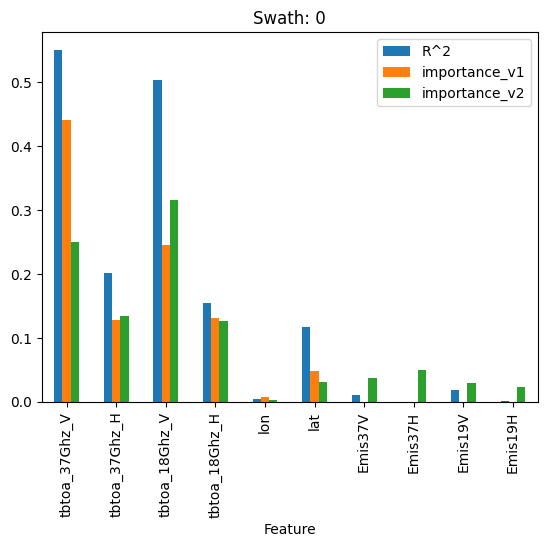

In [15]:
to_plot = results_df[[
    "Feature",
    "R^2",
    "importance_v1",
    "importance_v2"
]]

ax = to_plot.plot.bar(x = "Feature")
ax.set_title(f"Swath: {swath}")

In [16]:
# The same in one plot to show both swaths:


def get_swath_importance(swath: int):

    # Load the combined dataframe

    swath_ds= model_preprocess(ws_ds, swath_sector=swath, look="impute", add_look_flag=False)
    swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

    day_mapping = doy2month_mapping()
    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    df = df.drop(columns="month")

    df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    # Model v2 predictions
    print("Model v2")
    model = modelsv2[swath]

    # Predict for the local sample:
    X, y = xy_split(df, y_column = "surtep_ERA5")
    df["surtep_MODELv2"] = model.predict(X)
    df["v2_error"] = df["surtep_MODELv2"] - df["surtep_ERA5"] 

    # Calculate the error per pixel, group by lat and lon
    v2error_df = df[["lat","lon","v2_error"]]
    v2error_df.set_index(keys=["lat","lon"], inplace=True)
    v2error_df = v2error_df.groupby(by=["lat","lon"]).mean()
    v2error_df.reset_index(inplace=True)

    print("Variable importances")
    var_importances = permutation_importance(
    model, X, y,
    scoring="neg_median_absolute_error",
    max_samples= 0.1, # We have a lot of data, use only 10 % 
    n_repeats=3
    )

    # Get te results into a readable table:
    importance = var_importances.importances_mean
    importances ={var:value for var,value in zip(X.columns, importance)}

    # dataframe format
    importancesv2_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
    importancesv2_df["importance"] = importancesv2_df["importance [mse]"] / importancesv2_df["importance [mse]"].sum()


    # Pearson's R2 coeff
    print("Pearson's R2 coeffs")
    r2_values_list = []
    for column in X.columns:
        # Compute the Pearson correlation coefficient between the feature and y
        r = np.corrcoef(X[column], y)[0, 1]
        # Square the correlation coefficient to get R^2
        r2 = r**2
        # Append the result to the DataFrame
        r2_values_list.append({'Feature': column, 'R^2': r2})

    r2_values = pd.DataFrame(r2_values_list)

    model = modelsv1[swath]

    df = df[
        [
            'surtep_ERA5',
            'lat',
            'lon',
            'tbtoa_18Ghz_V',
            'tbtoa_18Ghz_H',
            'tbtoa_37Ghz_V',
            'tbtoa_37Ghz_H'
        ]
    ]

    # Predict for the local sample:
    X, y = xy_split(df, y_column = "surtep_ERA5")
    df["surtep_MODELv1"] = model.predict(X)
    df["v1_error"] = df["surtep_MODELv1"] - df["surtep_ERA5"] 


    # Calculate the error per pixel, group by lat and lon
    v1error_df = df[["lat","lon","v1_error"]]
    v1error_df.set_index(keys=["lat","lon"], inplace=True)
    v1error_df = v2error_df.groupby(by=["lat","lon"]).mean()
    v1error_df.reset_index(inplace=True)

    print("Variable importances")
    var_importances = permutation_importance(
    model, X, y,
    scoring="neg_median_absolute_error",
    max_samples= 0.1, # We have a lot of data, use only 10 % 
    n_repeats=3
    )

    # Get te results into a readable table:
    importance = var_importances.importances_mean
    importances ={var:value for var,value in zip(X.columns, importance)}

    # dataframe format
    importancesv1_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
    importancesv1_df["importance"] = importancesv1_df["importance [mse]"] / importancesv1_df["importance [mse]"].sum()


    # Combine all dataframes 

    results_df = r2_values.merge(importancesv2_df.reset_index(names="Feature"), how = "outer", on="Feature")
    results_df = results_df.merge(importancesv1_df.reset_index(names="Feature"), how = "outer", on="Feature", suffixes=("_v2","_v1"))        

    return results_df

In [17]:
# Run the function for both swaths:

swath2name = {
    0 : "Ascending",
    1 : "Descending"
}

result_list = []
for swath, _ in swath2name.items():
    print(f"{swath} swath")
    result_list.append(get_swath_importance(swath))

result_list[0]

Model v2
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 37s 698us/step
Variable importances
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 34s 654us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 528us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 532us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 592us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 615us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 696us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 721us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 906us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 596us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 659us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 641us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 646us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 736us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 579us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 605us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 595us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 601us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 591us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 605us/step
5237/5237 ━━━━━━━━━

,Feature,R^2,importance [mse]_v2,importance_v2,importance [mse]_v1,importance_v1
0,Emis19H,0.000470,0.560359,0.022798,NaN,NaN
1,Emis19V,0.019133,0.730738,0.029729,NaN,NaN
2,Emis37H,0.000118,1.201431,0.048879,NaN,NaN
3,Emis37V,0.010073,0.917084,0.037311,NaN,NaN
4,lat,0.116907,0.777257,0.031622,1.210322,0.047148
5,lon,0.004545,0.082657,0.003363,0.174586,0.006801
6,tbtoa_18Ghz_H,0.154947,3.116567,0.126794,3.356812,0.130764
7,tbtoa_18Ghz_V,0.504210,7.731750,0.314559,6.336599,0.246841
8,tbtoa_37Ghz_H,0.201923,3.321620,0.135137,3.252253,0.126691
9,tbtoa_37Ghz_V,0.551042,6.140213,0.249809,11.340210,0.441756


In [18]:
result_list[1]

,Feature,R^2,importance [mse]_v2,importance_v2,importance [mse]_v1,importance_v1
0,Emis19H,0.007266,0.555730,0.023583,NaN,NaN
1,Emis19V,0.009237,0.469381,0.019919,NaN,NaN
2,Emis37H,0.003265,0.876846,0.037210,NaN,NaN
3,Emis37V,0.001516,0.967194,0.041044,NaN,NaN
4,lat,0.082407,0.791361,0.033582,0.972493,0.056264
5,lon,0.005308,0.161621,0.006859,0.142665,0.008254
6,tbtoa_18Ghz_H,0.146942,3.673813,0.155902,2.208684,0.127785
7,tbtoa_18Ghz_V,0.330445,7.922760,0.336210,6.068471,0.351096
8,tbtoa_37Ghz_H,0.184206,3.588511,0.152282,2.671870,0.154583
9,tbtoa_37Ghz_V,0.403045,4.557714,0.193411,5.220194,0.302018


         Feature       R^2  importance_v1  importance_v2
0        Emis19H  0.000470            NaN       0.022798
1        Emis19V  0.019133            NaN       0.029729
2        Emis37H  0.000118            NaN       0.048879
3        Emis37V  0.010073            NaN       0.037311
4            lat  0.116907       0.047148       0.031622
5            lon  0.004545       0.006801       0.003363
6  tbtoa_18Ghz_H  0.154947       0.130764       0.126794
7  tbtoa_18Ghz_V  0.504210       0.246841       0.314559
8  tbtoa_37Ghz_H  0.201923       0.126691       0.135137
9  tbtoa_37Ghz_V  0.551042       0.441756       0.249809
         Feature       R^2  importance_v1  importance_v2
0        Emis19H  0.007266            NaN       0.023583
1        Emis19V  0.009237            NaN       0.019919
2        Emis37H  0.003265            NaN       0.037210
3        Emis37V  0.001516            NaN       0.041044
4            lat  0.082407       0.056264       0.033582
5            lon  0.005308     

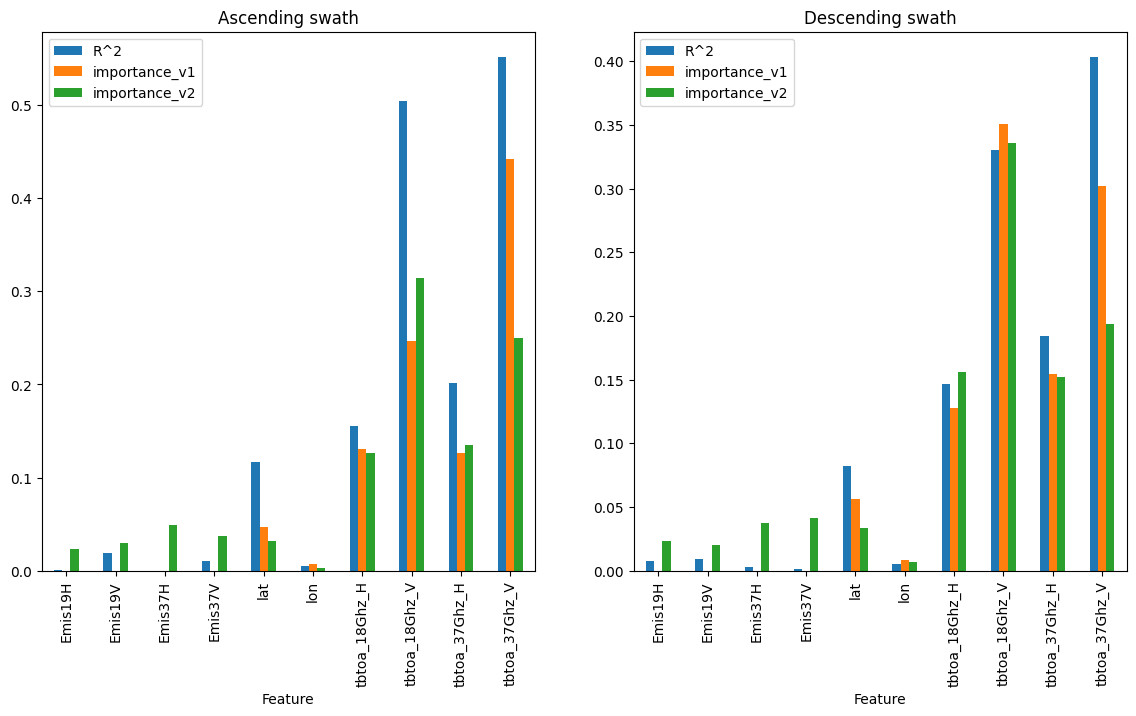

In [33]:
# Plot each barplot in a subplot

fig, axs = plt.subplots(1,2, figsize = (14,7))

for i, df in enumerate(result_list):

    to_plot = df[
        [
            "Feature",
            "R^2",
            "importance_v1",
            "importance_v2"
        ]
    ]

    ax = axs[i]

    to_plot.plot.bar(ax=ax, x="Feature")

    ax.set_title(f"{swath2name[i]} swath")

    ax.legend()


In [27]:
# Table format, concatenate the two dataframes in a way that makes sense. This is wors than just the barplots...
dvars = [ 
    "Feature",
    "R^2",
    "importance_v1",
    "importance_v2"
]
combined_results_df = result_list[0][dvars].merge(result_list[1][dvars], on="Feature",  suffixes=("_Asc", "_Des"))
combined_results_df[::-1]

,Feature,R^2_Asc,importance_v1_Asc,importance_v2_Asc,R^2_Des,importance_v1_Des,importance_v2_Des
9,tbtoa_37Ghz_V,0.551042,0.441756,0.249809,0.403045,0.302018,0.193411
8,tbtoa_37Ghz_H,0.201923,0.126691,0.135137,0.184206,0.154583,0.152282
7,tbtoa_18Ghz_V,0.504210,0.246841,0.314559,0.330445,0.351096,0.336210
6,tbtoa_18Ghz_H,0.154947,0.130764,0.126794,0.146942,0.127785,0.155902
5,lon,0.004545,0.006801,0.003363,0.005308,0.008254,0.006859
4,lat,0.116907,0.047148,0.031622,0.082407,0.056264,0.033582
3,Emis37V,0.010073,NaN,0.037311,0.001516,NaN,0.041044
2,Emis37H,0.000118,NaN,0.048879,0.003265,NaN,0.037210
1,Emis19V,0.019133,NaN,0.029729,0.009237,NaN,0.019919
0,Emis19H,0.000470,NaN,0.022798,0.007266,NaN,0.023583


C:\Users\andre\AppData\Local\Temp\ipykernel_7008\2311707552.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["" for _ in range(len(to_plot["Feature"]))])


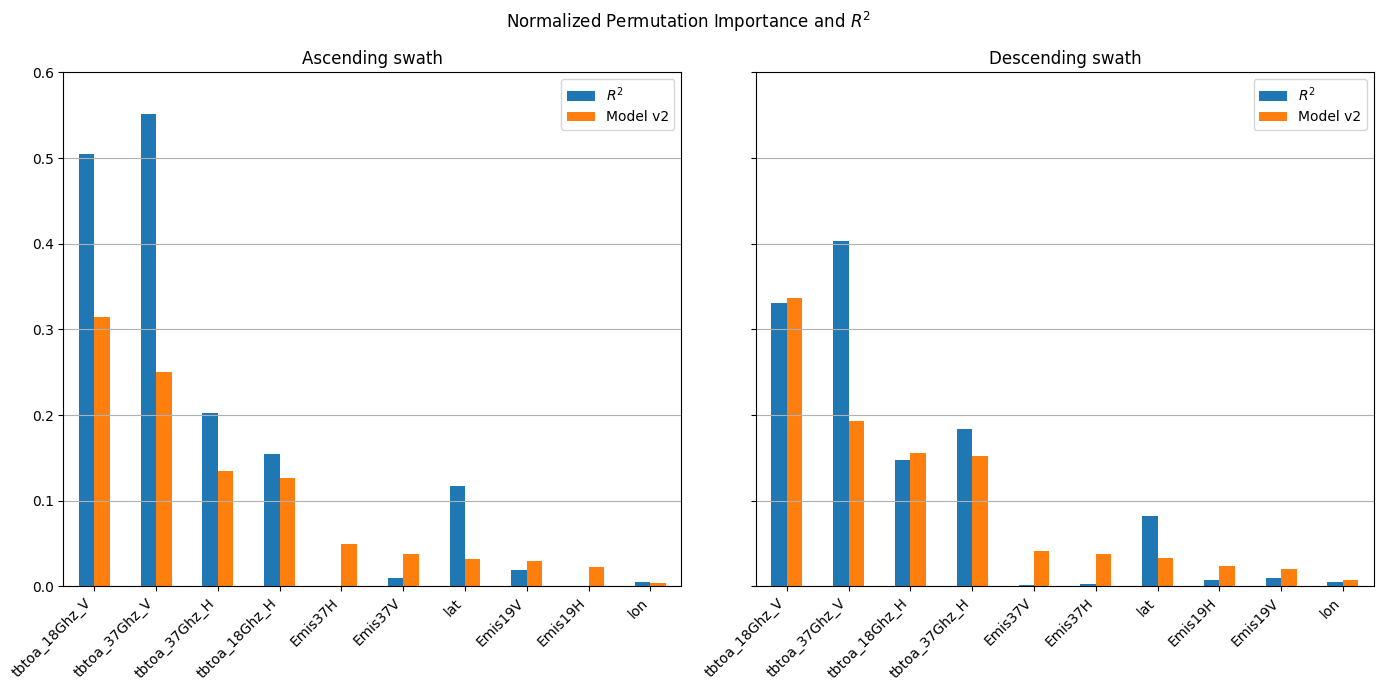

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, df in enumerate(result_list):
    # Seleccionar las columnas necesarias
    to_plot = df[
        [
            "Feature",
            "R^2",
            # "importance_v1",
            "importance_v2"
        ]
    ]
    
    # Ordenar los datos por la columna "R^2" de forma descendente
    to_plot = to_plot.sort_values(by="importance_v2", ascending=False)

    ax = axs[i]
    
    # Crear el gráfico de barras
    to_plot.plot.bar(ax=ax, x="Feature")

    ax.set_title(f"{swath2name[i]} swath")

    
    # Rotar las etiquetas del eje X y ajustar su alineación
    ax.set_xticklabels(to_plot["Feature"], rotation=45, ha="right")
    ax.set_xlabel("")

    ax.set_ylim([0,0.60])
    ax.grid(axis="y")

    ax.legend([
        "$R^2$",
        "Model v2"
    ])


    if i == 1:
        ax.set_yticklabels(["" for _ in range(len(to_plot["Feature"]))])

fig.suptitle("Normalized Permutation Importance and $R^2$")
plt.tight_layout()
plt.show()
